In [1]:
import Utilities.prelude
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import k3match
from scipy.optimize import fsolve
import pickle 
import math 

from src.shock_zone import shock_direction, find_prepost
from Utilities.operators import make_tree, calc_grad

# %matplotlib widget # (to go back normal %matplotlib inline)
# mpl.rcParams['figure.dpi'] = 100

In [2]:
z_chosen = 0
mach_min = 1.3
gamma = 5/3
save = True
folder = 'sedov'
snap = '100'
path = f'{folder}/{snap}'

if folder == 'TDE':
    is_tde = True
    epsilon = 2
    # threshold = 7_000
else:
    is_tde = False
    epsilon = 0.02
    # threshold = 0.99

In [3]:
def find_prepost(sim_tree, X, Y, Z, point, check_point, ds, delta, direction):
    """ Find the previous/next point along the shock direction.
    Parameters
    -----------
    point: array.
        Starting point.
    ds: array (1x3)
        Shock direction.
    delta: float.
        Step to do to search.
    direction: str.
        Choose if you want to move towards the 'pre' or 'post' shock region.
    Returns
    -----------
    idx: int.
        Tree index of the previous/next point along the shock direction.
    """
    if direction == 'post':
        delta = - delta

    k = 1
    # check that you are not taking the same point as the one given
    distance = 0
    while distance == 0:
        new_point = point + k * delta * ds 
        _, idx  = sim_tree.query(new_point)
        new_point = np.array([X[idx], Y[idx], Z[idx]])
        distance = math.dist(check_point, new_point)
        k += 0.1

    k -=0.1 #becuase you have added it in the end
    final_step = k*np.abs(delta)
    return idx, final_step


In [4]:
def ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, all_idx, idx, div, dir, direction):
    """ Start from one cell and walk along the shock direction till you go out the shock zone accoridng to Schaal14 (par 2.3.3).
    Parameters
    -----------
    sim_tree: tree.
        Simualation points. 
    X, Y, Z: arrays.
        Points coordinates.
    are_u_shock: bool array.
        Says if a simulation cell is in the shock zone.
    x_zone, y_zone, z_zone: arrays.
        Shock zone points coordinates.
    all_idx: array.
        Tree indeces identifying the cells in the shock zone.
    idx: int.
        Index of the chosen point between the one in the shock zone.
    div: array.
        Velocity divergence of the shock zone points.
    dir: 3D-array.
        Shock direction of the shock zone points.
    delta: float.
        Step you do from your chosen point. It has to be positive!
    direction: str.
        Choose if you want to move towards the 'pre' or 'post' shock region.
    Returns:
    -----------
    final_tree_index: int.
        Tree index of the pre/post shock cell corresponding to the starting one.
    """
    # Take the necessary info of your starting point 
    x_point = x_zone[idx]
    y_point = y_zone[idx]
    z_point = z_zone[idx]   
    point = np.array([x_point, y_point, z_point])
    r_point = np.linalg.norm(point)
    div_v = div[idx]
    dir_sh = np.array(dir[idx])
    
    _, _, dist = k3match.cartesian(X,Y,Z, x_point, y_point, z_point, 2*r_point)
    dist = np.delete(dist, np.argmin(dist))
    delta = np.min(dist)
    
    # Walk till you go out the shock zone
    check_zone = True 
    check_point = point
    while check_zone == True:
        # Find the next point
        i_tree, final_step = find_prepost(sim_tree, X, Y, Z, point, check_point, dir_sh, delta, direction)

        # check if it's in the shock zone
        check_zone = are_u_shock[i_tree]

        if check_zone == True:
            # there will be a index in all_idx equal to i_tree. Find it. 
            idx_zone = np.argmin(np.abs(i_tree-all_idx))  
            # Take the div and dir of that (shock zone) point.
            div_next = div[idx_zone]
            dir_next = dir[idx_zone]

            # if lower div v, you discard the ray.
            if div_next < div_v:
                return False # and then you don't take this cell

            # if opposite direction in shocks, you turn/stop.
            if np.dot(dir_sh, dir_next) < 0:
                check_zone = False # so you exit from the while
        
        check_point = np.array([X[i_tree], Y[i_tree], Z[i_tree]])
        delta = final_step
 
    final_tree_index = i_tree
    
    return final_tree_index

def shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, x_zone, y_zone, z_zone, all_idx, div, dir):
    """ 
    Find among the cells in the shock zone the one in the shock surface 
    (output: indeces referring to the shockzonefile) 
    and its pre/post shock cells (output: tree indeces).
    """
    surface_Tmach = []
    surface_Pmach = []
    surface_Denmach = []

    #indeces referring to the shockzone file: you use them on xyz_zone and dir
    indeces = [] 
    # indeces referring to the list of ALL simulation cells: you use them on XYZ
    indeces_pre = []
    indeces_post = []

    # loop over all the cells in the shock zone
    for idx in range(len(x_zone)):
        # print(idx)
        post_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, 
                                     all_idx, idx, div, dir, direction = 'post')
        if post_tree_index == False:
            continue
        else:
            Tpost = Temp[post_tree_index]
            pre_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, 
                                        all_idx, idx, div, dir, direction = 'pre')
            if pre_tree_index == False:
                continue
            else:
                Tpre = Temp[pre_tree_index]

                Tbump = Tpost/Tpre
                # check if the Tbump is in the same direction of ds 
                if Tbump < 1:
                    continue 

                # We should also avoid the cells with Tbump< than the one (1.2921782544378697) inferred from M=M_min... So condition 2 doesn't work in shock zone?
                if Tbump < 1.292:
                    continue 

                indeces.append(idx)
                indeces_pre.append(pre_tree_index)
                indeces_post.append(post_tree_index)

                def temperature_bump(mach):
                    to_solveT =  ((gamma-1) * mach**2 + 2) * (2 * gamma * mach**2 - (gamma-1)) / ((gamma+1)**2 * mach**2) - Tbump
                    return to_solveT
                
                Ppre = Press[pre_tree_index]
                Ppost = Press[post_tree_index]
                Pbump = Ppost/Ppre
                Denpre = Den[pre_tree_index]
                Denpost = Den[post_tree_index]
                Denbump = Denpost/Denpre

                def pressure_bump(mach):
                    to_solveP = (2 * gamma * mach**2 - (gamma-1)) / (gamma+1) - Pbump
                    return to_solveP

                def density_bump(mach):
                    to_solverho = (gamma+1) * mach**2 / (mach**2 * (gamma-1) + 2) - Denbump
                    return to_solverho
                
                Tmach = fsolve(temperature_bump, 1.5)
                Pmach = fsolve(pressure_bump, 1.5)
                Denmach = fsolve(density_bump, 1.5)

                surface_Tmach.append(Tmach)
                surface_Pmach.append(Pmach)
                surface_Denmach.append(Denmach)
            
    surface_Tmach = np.array(np.concatenate(surface_Tmach))
    surface_Pmach = np.array(np.concatenate(surface_Pmach))
    surface_Denmach = np.array(np.concatenate(surface_Denmach))
    indeces = np.array(indeces)
    indeces_pre = np.array(indeces_pre)
    indeces_post = np.array(indeces_post)

    return surface_Tmach, surface_Pmach, surface_Denmach, indeces, indeces_pre, indeces_post


In [5]:
# Import data
with open(f'data/{snap}/shockbool_{snap}.pkl', 'rb') as filebool:
    are_u_shock = pickle.load(filebool)
    
shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
shockdir = np.loadtxt(f'data/{snap}/shockdir_{snap}.txt')

x_zone = shockzone[0]
y_zone = shockzone[1]
z_zone = shockzone[2]
div = shockzone[3]
Tzone = shockzone[4]
idx_tree = shockzone[5]

x_dir = shockdir[0]
y_dir = shockdir[1]
z_dir = shockdir[2]
dir = []
for i in range(len(x_dir)):
    dir.append([x_dir[i], y_dir[i], z_dir[i]])

In [6]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path, snap, is_tde)
dim_cell = (3*Vol/(4*np.pi))**(1/3)

all T=0, bro. Compute by myself!


In [7]:
surface_Tmach, surface_Pmach, surface_Denmach, indeces, indeces_pre, indeces_post = shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, x_zone, y_zone, z_zone, idx_tree, div, dir)

In [8]:
if save == True:
    #surface_mach_txt = np.concatenate(surface_Tmach)
    with open(f'data/{snap}/shocksurface_{snap}.txt', 'w') as file:
        file.write(f'# Indeces of the shock zone points that are in the shock surface (I.E. they refer to the shockzone file) \n') 
        file.write(' '.join(map(str, indeces)) + '\n')
        file.write('# mach number according to T jump\n') 
        file.write(' '.join(map(str, surface_Tmach)) + '\n')
        file.write('# mach number according to P jump\n') 
        file.write(' '.join(map(str, surface_Pmach)) + '\n')
        file.write('# mach number according to Dem jump\n') 
        file.write(' '.join(map(str, surface_Denmach)) + '\n')
        file.write(f'# Tree indeces of the pre shock zone points corresponding to the shock surface points \n') 
        file.write(' '.join(map(str, indeces_pre)) + '\n')
        file.write(f'# Tree indeces of the post shock zone points corresponding to the shock surface points \n') 
        file.write(' '.join(map(str, indeces_post)) + '\n')
        file.close()
    

In [9]:
surface_x = x_zone[indeces]
surface_y = y_zone[indeces]
surface_z = z_zone[indeces]
surface_dirx = x_dir[indeces]
surface_diry = y_dir[indeces]

post_x = X[indeces_post]
post_y = Y[indeces_post]
post_z = Z[indeces_post]
pre_x = X[indeces_pre]
pre_y = Y[indeces_pre]
pre_z = Z[indeces_post]


In [10]:
surface_z[surface_Tmach<10]

array([], dtype=float64)

In [11]:
# Cross section
zone_cross_x = x_zone[np.abs(z_zone-z_chosen)< epsilon]
zone_cross_y = y_zone[np.abs(z_zone-z_chosen)< epsilon]

surface_cross_x = surface_x[np.abs(surface_z-z_chosen)<epsilon]
surface_cross_y = surface_y[np.abs(surface_z-z_chosen)<epsilon]

cross_shockdirx = surface_dirx[np.abs(surface_z-z_chosen)<epsilon]
cross_shockdiry = surface_diry[np.abs(surface_z-z_chosen)<epsilon]

zone_post_x = post_x[np.logical_and(np.abs(surface_z-z_chosen)<epsilon, np.abs(post_z-z_chosen)<epsilon)] # post_x[np.abs(surface_z-z_chosen)<epsilon] 
zone_post_y = post_y[np.logical_and(np.abs(surface_z-z_chosen)<epsilon, np.abs(post_z-z_chosen)<epsilon)] # post_y[np.abs(surface_z-z_chosen)<epsilon]

zone_pre_x = pre_x[np.logical_and(np.abs(surface_z-z_chosen)<epsilon, np.abs(pre_z-z_chosen)<epsilon)] # pre_x[np.abs(surface_z-z_chosen)<epsilon]
zone_pre_y = pre_y[np.logical_and(np.abs(surface_z-z_chosen)<epsilon, np.abs(pre_z-z_chosen)<epsilon)] # pre_y[np.abs(surface_z-z_chosen)<epsilon]


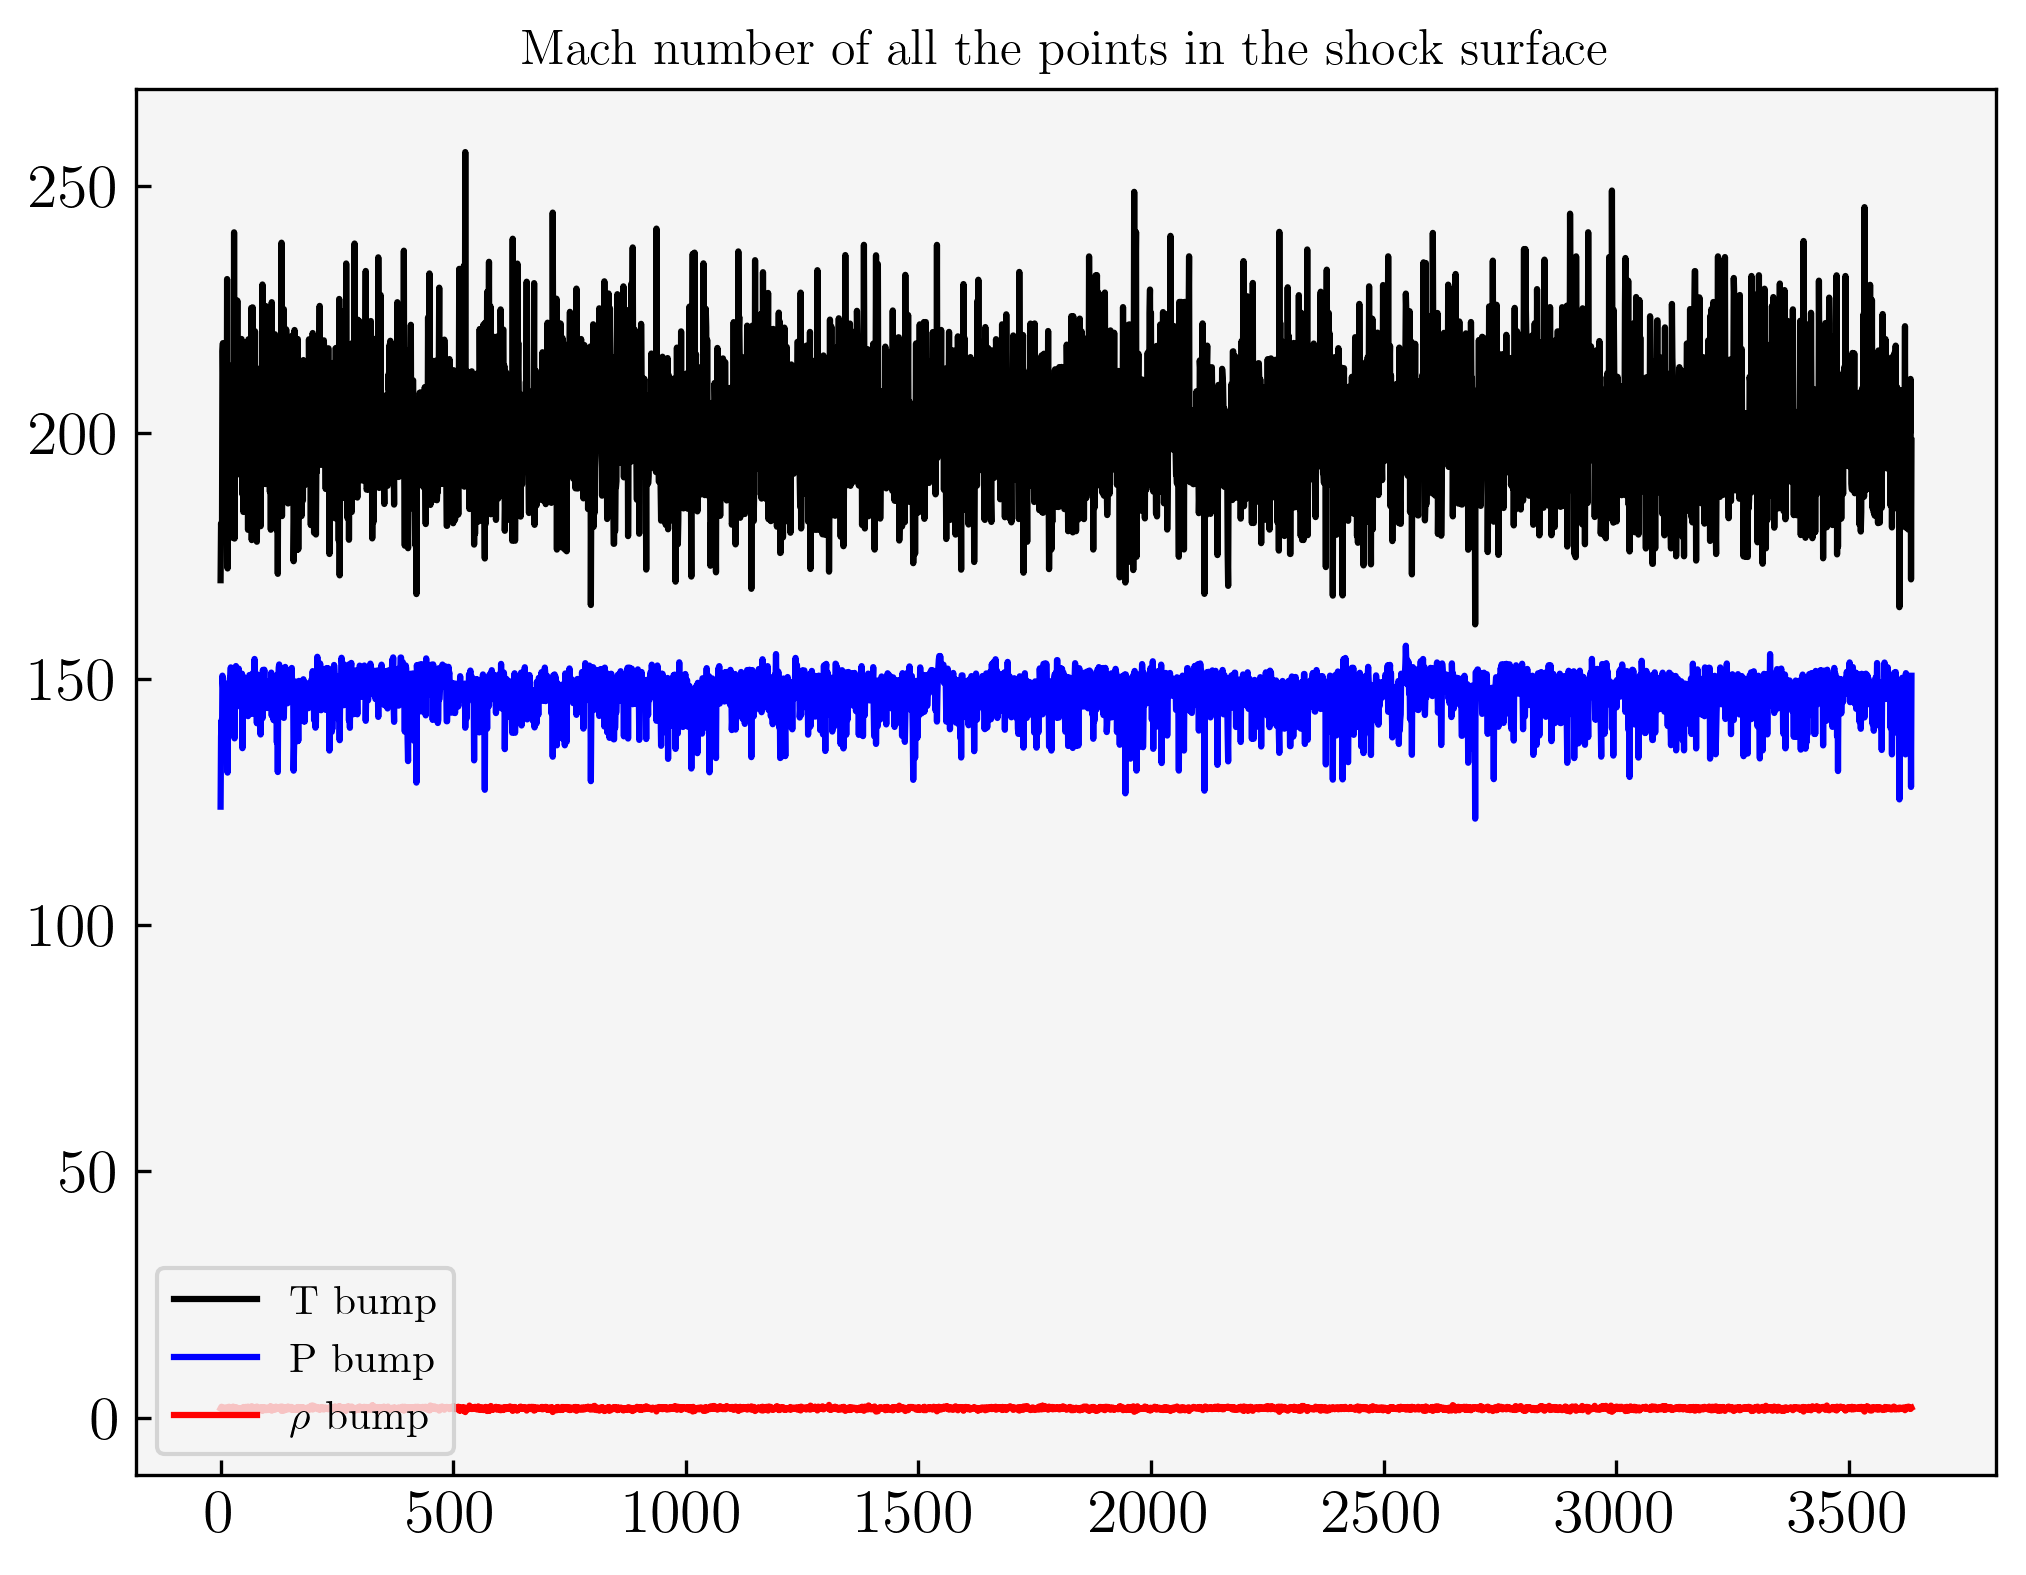

In [12]:
plt.plot(surface_Tmach, c = 'k', label = 'T bump')
plt.plot(surface_Pmach, c = 'b', label = 'P bump')
plt.plot(surface_Denmach, c = 'r', label = r'$\rho$ bump')
plt.title(f'Mach number of all the points in the shock surface')
plt.legend(loc = 'lower left')
if save:
    plt.savefig(f'Figs/{snap}/beforemach{snap}.png')

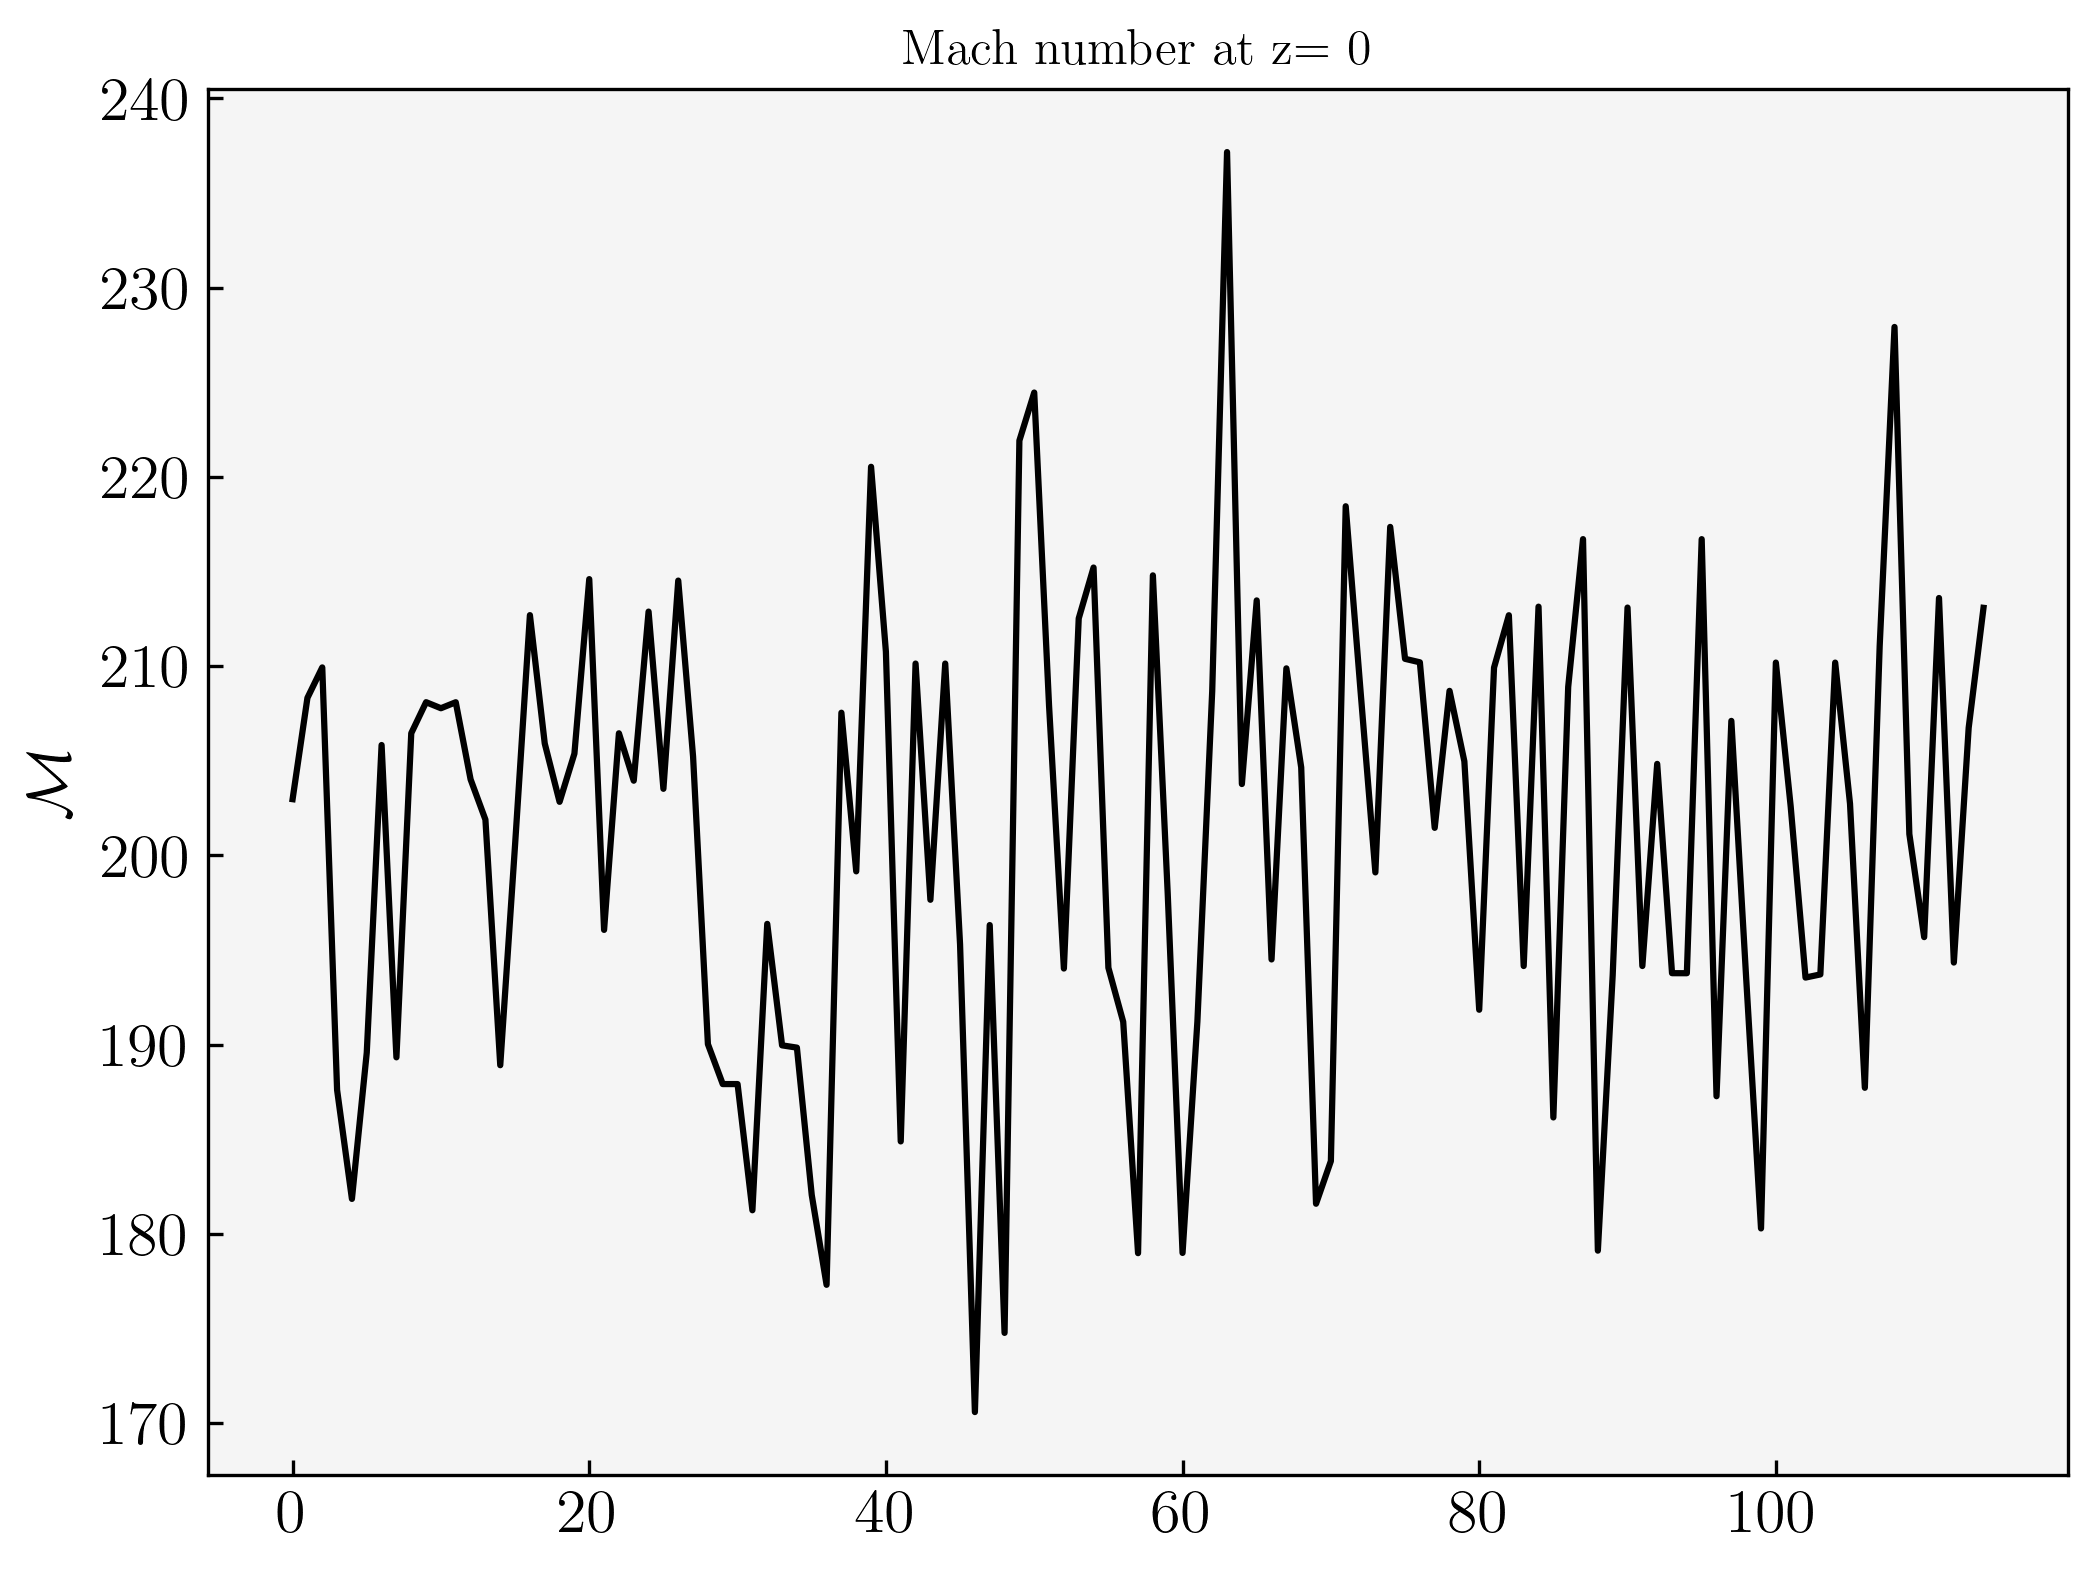

In [13]:
plt.plot(surface_Tmach[np.abs(surface_z-z_chosen)<epsilon], c = 'k')
# plt.scatter(outlier, surface_mach[np.logical_and(surface_z<z_chosen+step, surface_z>z_chosen-step)][outlier], c = 'r')
plt.ylabel(r'$\mathcal{M}$', fontsize = 15)
plt.title(f'Mach number at z= {z_chosen}')
if save == True:
  plt.savefig(f'Figs/{snap}/mach{snap}_z{z_chosen}.png')
plt.show()

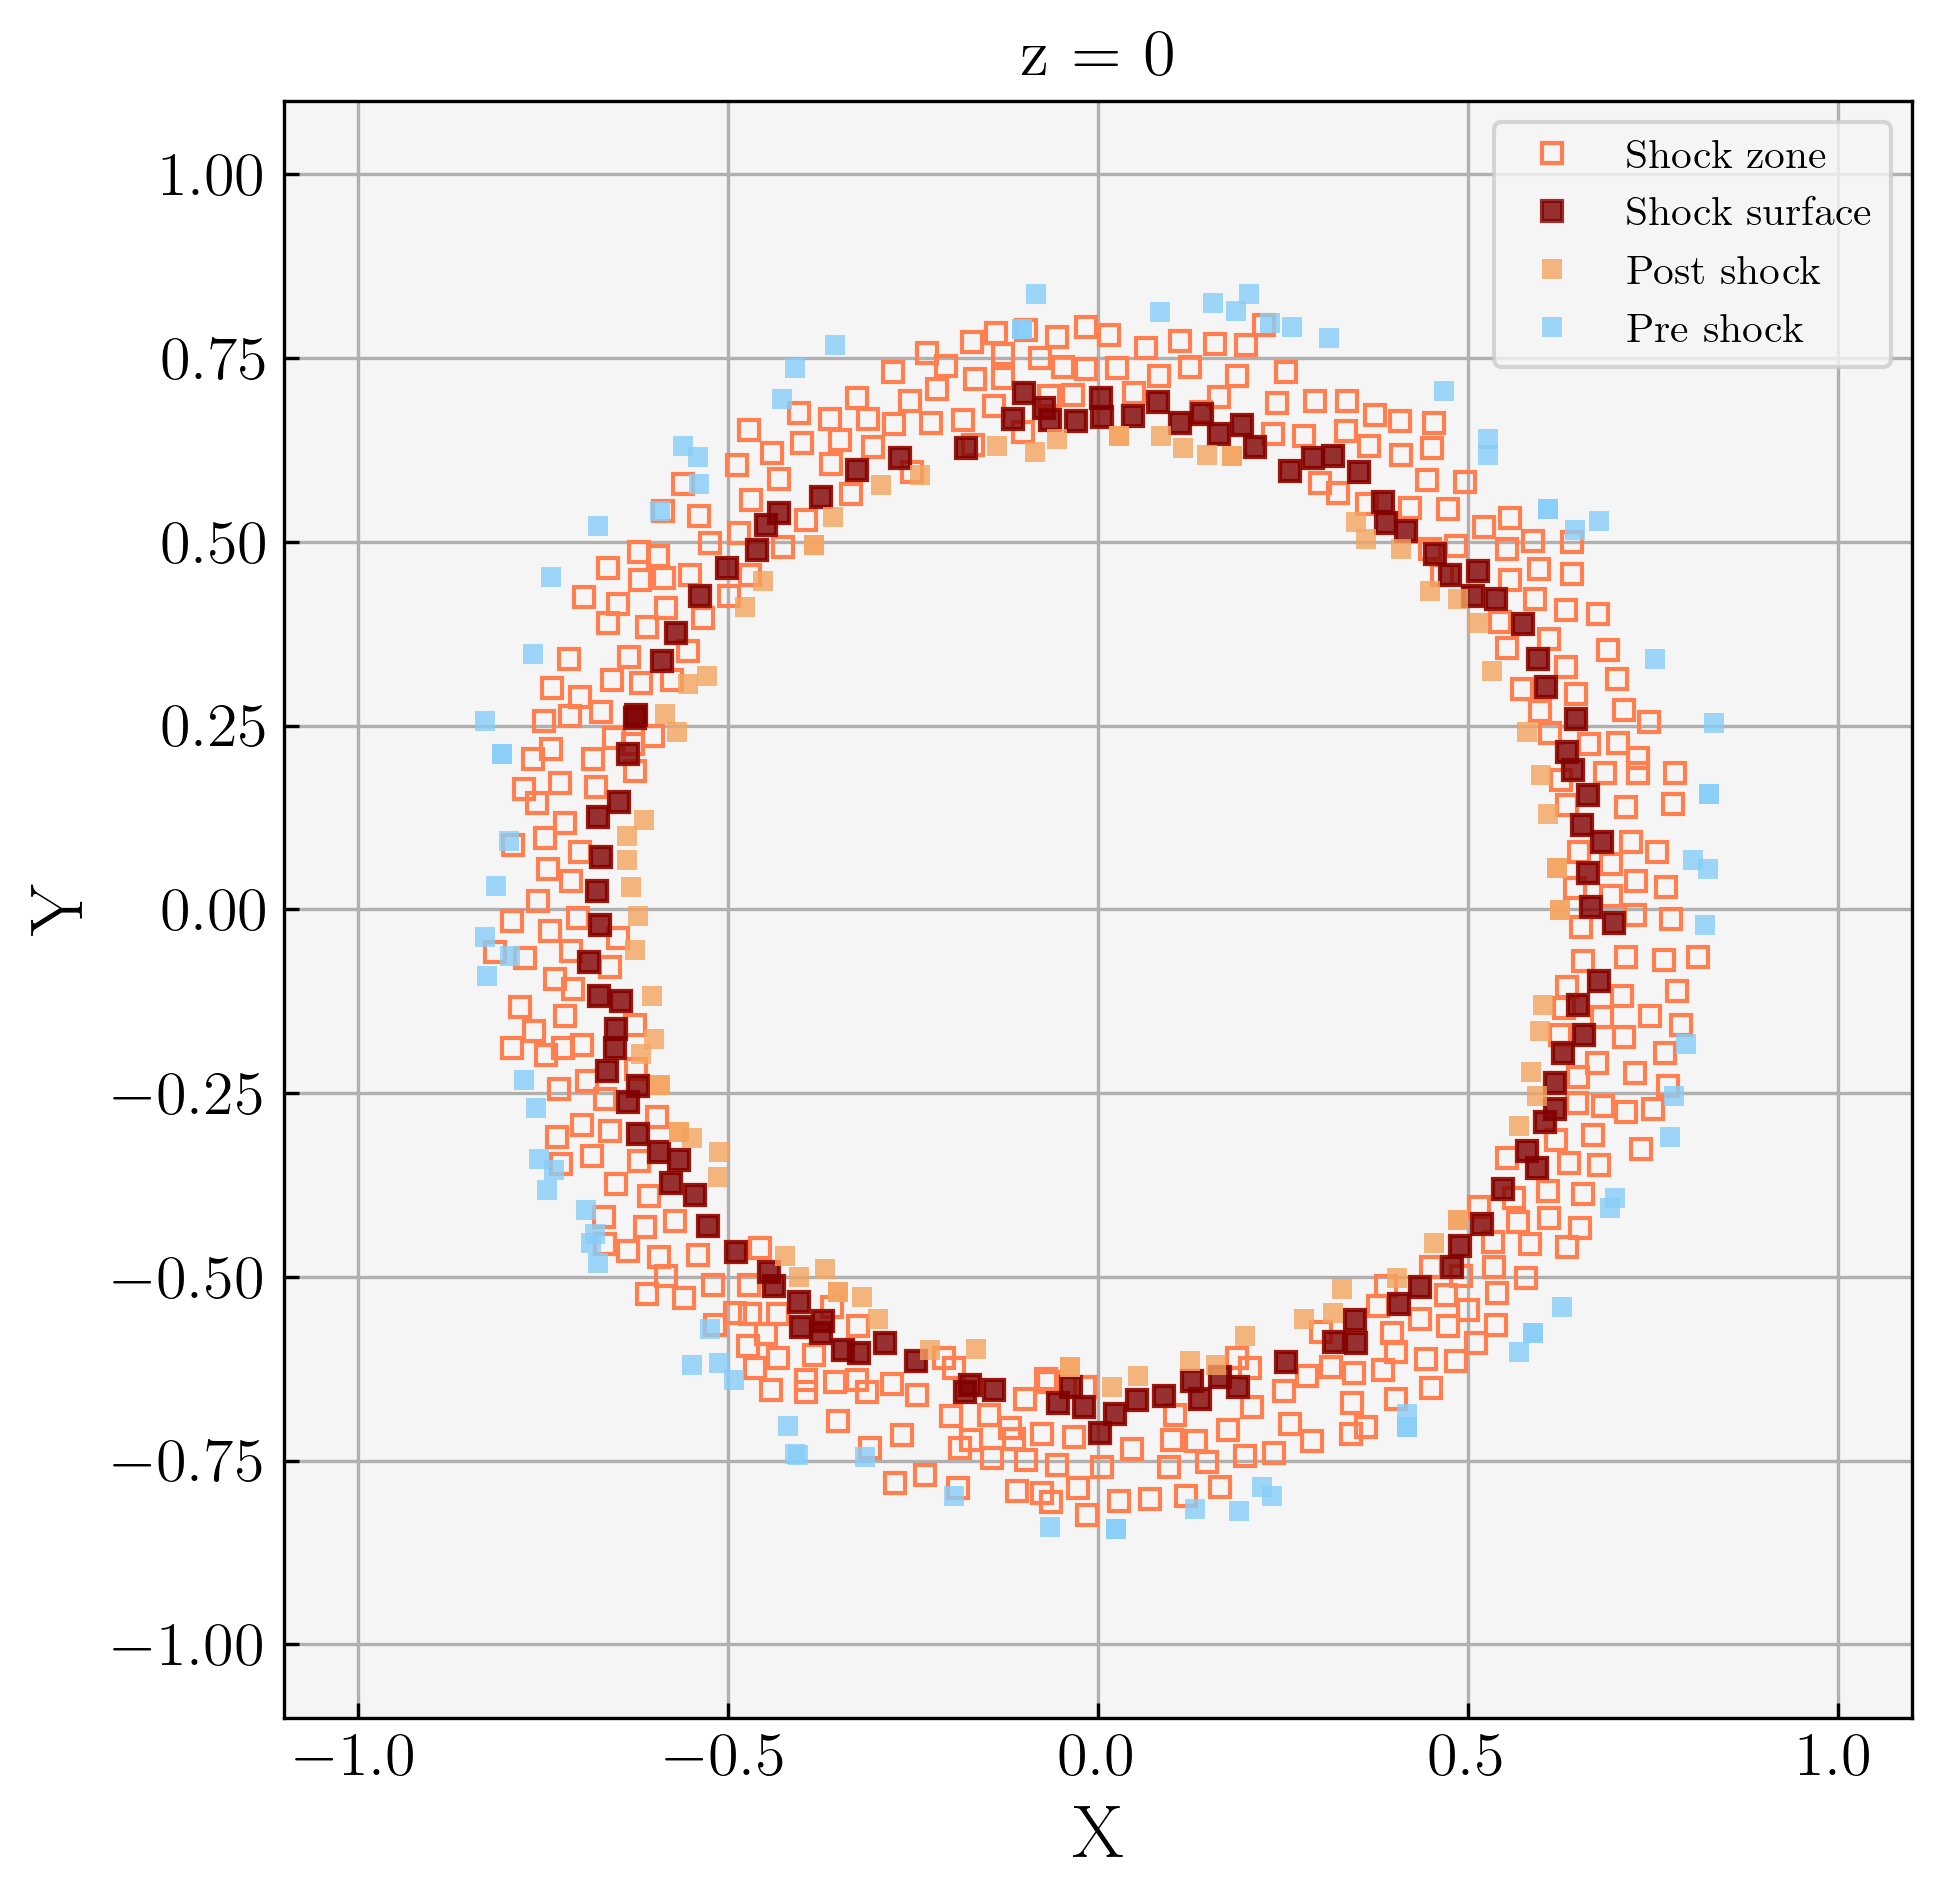

In [14]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='coral', label = 'Shock zone')
ax.plot(surface_cross_x, surface_cross_y, 'ks', markerfacecolor='maroon', ms = 5, markeredgecolor='maroon',  alpha = 0.8, label = 'Shock surface')

#ax.quiver(surface_cross_x, surface_cross_y, cross_shockdirx, cross_shockdiry, color = 'k', angles='xy', scale_units='xy', scale = 2)
ax.plot(zone_post_x, zone_post_y, 'ks', markerfacecolor='sandybrown', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Post shock')
ax.plot(zone_pre_x, zone_pre_y, 'ks', markerfacecolor='lightskyblue', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Pre shock')

# ax.plot(surface_cross_x[outlier], surface_cross_y[outlier], 'ks', markerfacecolor='r', ms = 7, markeredgecolor='r',  label = 'outlier')
# ax.plot(post_x[slice_surface][outlier], post_y[slice_surface][outlier], 'ks', markerfacecolor='orange', ms = 7, markeredgecolor='orange',  label = 'outlier post')
# ax.plot(pre_x[slice_surface][outlier], pre_y[slice_surface][outlier], 'ks', markerfacecolor='b', ms = 7, markeredgecolor='b',  label = 'outlier pre')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_xlabel('X', fontsize = 18)
ax.set_ylabel('Y', fontsize = 18)
ax.legend()
ax.set_title(f'z = {z_chosen}', fontsize = 16)
plt.grid()
if save == True:
    plt.savefig(f'Figs/{snap}/5shocksurface_z{z_chosen}_{snap}.png')
plt.show()

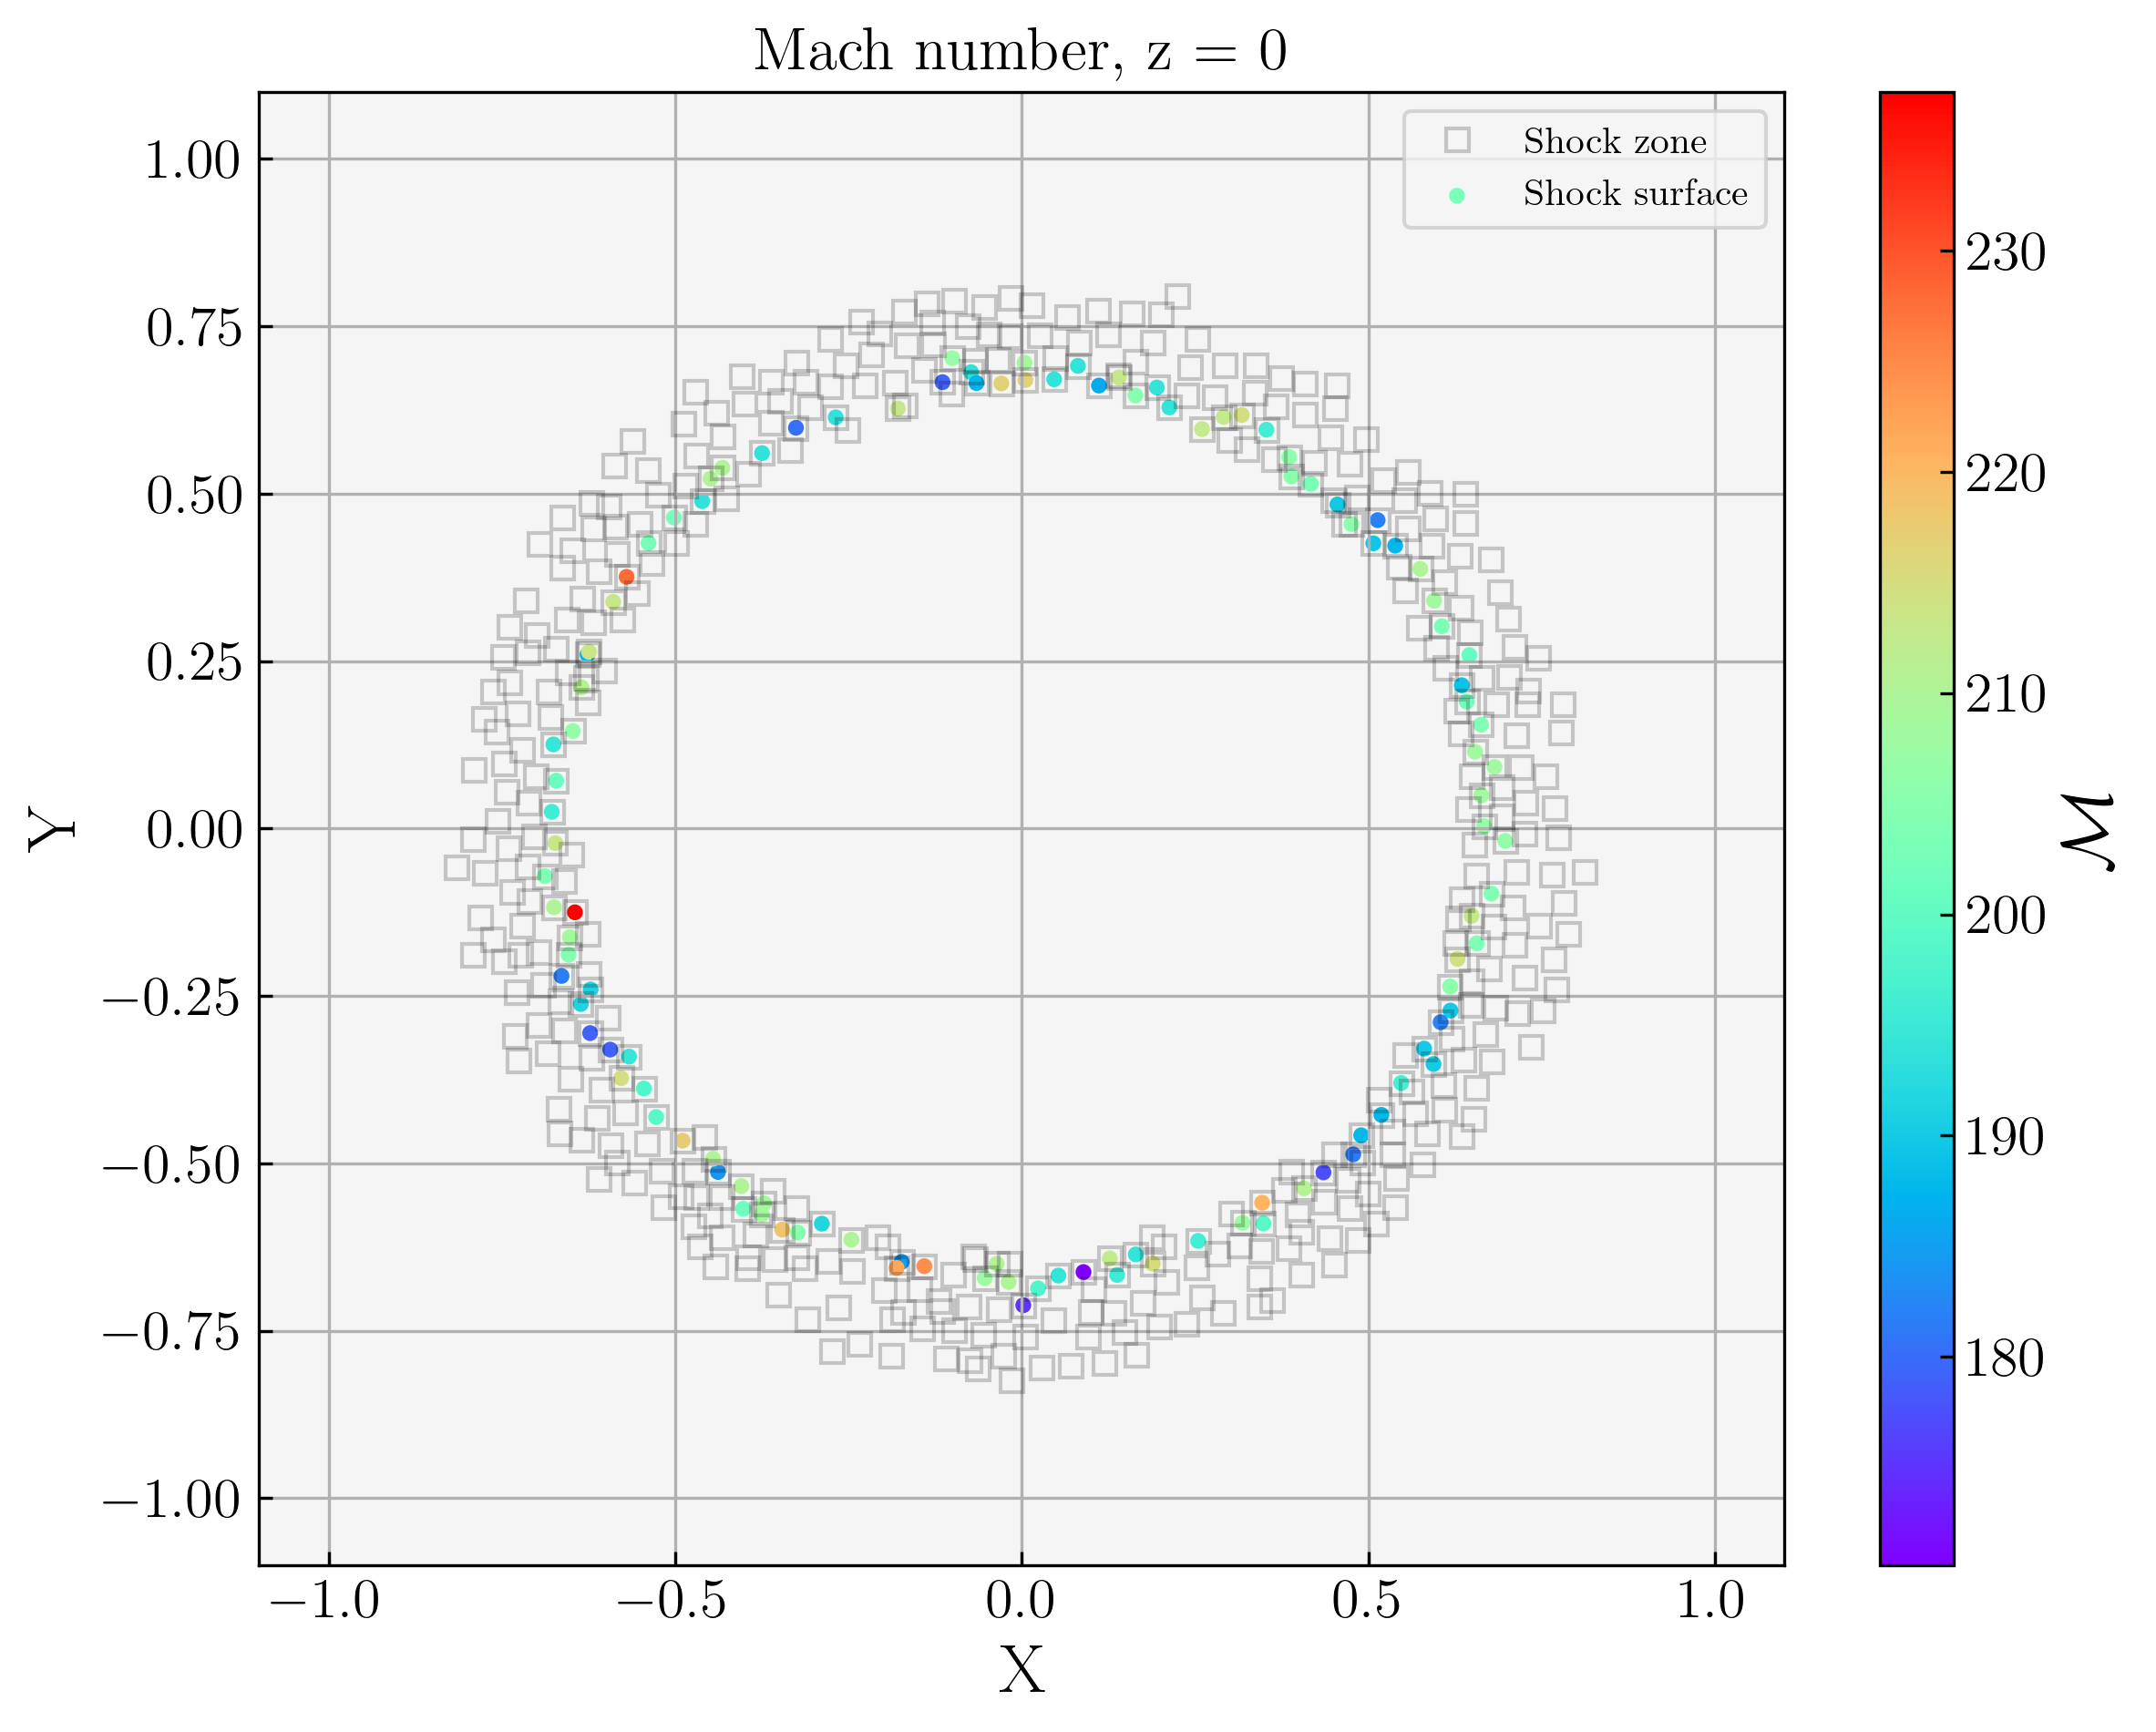

In [15]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
fig, ax = plt.subplots(1,1, figsize = (9,7))
if folder == 'sedov':
    ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 6, markeredgecolor='k', alpha = 0.2, label = 'Shock zone')
    img = ax.scatter(surface_cross_x, surface_cross_y, c = surface_Tmach[np.abs(surface_z-z_chosen)<epsilon], s=10,  cmap = 'rainbow', label = 'Shock surface')#, vmin = 110, vmax = 160)
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlabel('X', fontsize = 18)
    ax.set_ylabel('Y', fontsize = 18)
    ax.set_title(f'Mach number, z = {z_chosen}', fontsize = 16)
else: 
    img = ax.scatter(surface_x/20_000, surface_y/20_000, c = surface_Tmach, label = 'Shock surface', cmap = 'rainbow')#, vmin=0, vmax = 5)
    #plt.plot(x_zone/20_000, y_zone/20_000, 'ks',  markerfacecolor='none', ms=5, markeredgecolor='k', label = 'shock zone')
    plt.ylim(-0.3, 0.2)
    plt.xlim(-1,0.05)
    plt.xlabel(r'X [x/$R_a$]', fontsize = 18)
    plt.ylabel(r'Y [x/$R_a$]', fontsize = 18)
cbar = plt.colorbar(img)
cbar.set_label(r'$\mathcal{M}$', fontsize = 19)
ax.legend()
plt.grid()
if save == True:
    plt.savefig(f'Figs/{snap}/5shocksurfaceMach_z{z_chosen}_{snap}.png')
plt.show()